In [1]:
import pandas as pd
import statsmodels.api as sm

# Load the Auto dataset
auto = sm.datasets.get_rdataset("Auto", "ISLR").data

# Select specific columns
auto_subset = auto[['acceleration', 'horsepower', 'weight','mpg']]

# Check dimensions
print(auto_subset.shape)


(392, 4)


In [2]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
(LinearRegression ,
LogisticRegression ,
Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
(train_test_split ,
GridSearchCV)

from ISLP.torch import (SimpleDataModule ,
SimpleModule ,
ErrorTracker ,
rec_num_workers)

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
from torch.utils.data import TensorDataset

In [3]:
auto_subset.head()

,acceleration,horsepower,weight,mpg
rownames,,,,
1,12.0,130,3504,18.0
2,11.5,165,3693,15.0
3,11.0,150,3436,18.0
4,12.0,150,3433,16.0
5,10.5,140,3449,17.0


In [4]:
from torchmetrics import (MeanAbsoluteError ,
R2Score)
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True , warn_only=True)

Seed set to 0


In [5]:
X = auto_subset[['acceleration','weight','horsepower']]
Y = auto_subset[['mpg']]
Y = Y.to_numpy()
X = X.to_numpy()
type(X)
# Y

numpy.ndarray

In [6]:
(X_train,X_test,Y_train,Y_test) = train_test_split(X,Y,test_size=1/3,random_state=1)
X_train.shape
type(X_train)

numpy.ndarray

In [7]:
class FFNN(nn.Module):
    def __init__(self , input_size):
        super(FFNN , self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
        nn.Linear(input_size , 60),
        nn.ReLU(),
        nn.Dropout (0.5),
        nn.Linear(60, 1))
    def forward(self , x):
        x = self.flatten(x)
        return self.sequential(x).squeeze(-1)
        # return torch.flatten(self.sequential(x))

In [8]:
ffmodel = FFNN(X.shape[1])
ffmodel

FFNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=3, out_features=60, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=60, out_features=1, bias=True)
  )
)

In [9]:
summary(ffmodel,
input_size=X.shape,
col_names=['input_size',
'output_size',
'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
FFNN                                     [392, 3]                  [392]                     --
├─Flatten: 1-1                           [392, 3]                  [392, 3]                  --
├─Sequential: 1-2                        [392, 3]                  [392, 1]                  --
│    └─Linear: 2-1                       [392, 3]                  [392, 60]                 240
│    └─ReLU: 2-2                         [392, 60]                 [392, 60]                 --
│    └─Dropout: 2-3                      [392, 60]                 [392, 60]                 --
│    └─Linear: 2-4                       [392, 60]                 [392, 1]                  61
Total params: 301
Trainable params: 301
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.00
Estimated Total Size (MB): 0.20

In [10]:
X = torch.tensor(X.astype(np.float32))
Y = torch.tensor(Y.astype(np.float32)).view(-1)
fnn_train = TensorDataset(X,Y)
#X.shape
Y.shape

torch.Size([392])

In [11]:
fnn_train[1:5]

(tensor([[  11.5000, 3693.0000,  165.0000],
         [  11.0000, 3436.0000,  150.0000],
         [  12.0000, 3433.0000,  150.0000],
         [  10.5000, 3449.0000,  140.0000]]),
 tensor([15., 18., 16., 17.]))

In [12]:
max_num_workers = rec_num_workers()

ffn_dm = SimpleDataModule(fnn_train,
fnn_train,
batch_size=50,
num_workers=min(4,max_num_workers),
validation=fnn_train)

In [13]:
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Sample from dataset: {fnn_train[0]}")

X shape: torch.Size([392, 3]), Y shape: torch.Size([392])
Sample from dataset: (tensor([  12., 3504.,  130.]), tensor(18.))


In [14]:
ffn_module = SimpleModule.regression(ffmodel,
metrics={'mae':MeanAbsoluteError()})

logger = CSVLogger('logs', name='fnn')

In [15]:
ff_trainer = Trainer(deterministic=True,
max_epochs=30,
log_every_n_steps=5,
logger=logger,
callbacks=[ErrorTracker()])
ff_trainer.fit(ffn_module,datamodule=ffn_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | FFNN    | 301    | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  0.84it/s, v_num=12]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 77.65it/s, v_num=12]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 67.92it/s, v_num=12]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.66it/s, v_num=12]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████████

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 31.27it/s, v_num=12]


In [16]:
ff_trainer.test(ffn_module , datamodule=ffn_dm)

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 111.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            179.0413818359375
        test_mae            11.442255973815918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 179.0413818359375, 'test_mae': 11.442255973815918}]

In [23]:
preds = ffn_module(X)
torch.abs(Y-preds).mean()

tensor(12.1297, grad_fn=<MeanBackward0>)

In [24]:
print(preds[1:5])

tensor([34.1427, 11.3873, 32.9119,  5.8711], grad_fn=<SliceBackward0>)


In [25]:
print(Y[1:5])

tensor([15., 18., 16., 17.])


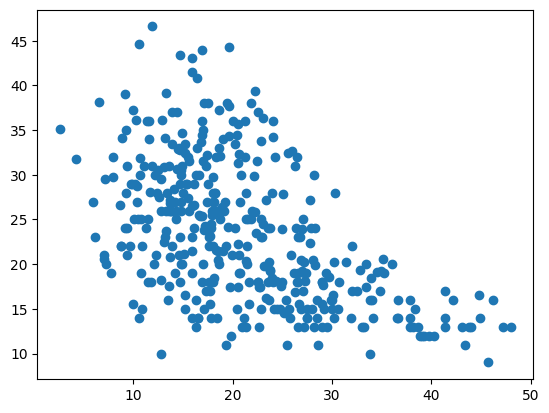

In [18]:
import matplotlib.pyplot as plt
plt.plot(preds.detach().numpy(),Y.detach().numpy(),'o')
plt.show()